# TODO: AWS Capostone project - Inventory Monitoring at Distribution Centers
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.
This project consists of the main code for the AWS Machine Learning Engineer Path, provided by Udacity. It is based on the started code, provided by Udacity [github repo](https://github.com/udacity/nd009t-capstone-starter). The main idea is to implement a Machine Learinig model to be able to identify the number of object's that are present in a bin. Part of the specific's case scenario, same concept can be applied also more general and in many different scenarios, as the recent COVID19 pandemic has shown to us.
As a note, for this notebook the ```conda_amazonei_pytorch_latest_p37``` kernel was used.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [4]:
# TODO: Install any packages that you might need
!pip install -U sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [5]:
!pip install -U smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
!pip install -U opencv-python torchvision tqdm pillow --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 216.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torcheia 1.0.0 requires torch==1.5.1, but you have torch 1.13.1 which is incompatible.


In [3]:
# TODO: Import any packages that you might need
import sagemaker
import boto3
import os, shutil
from pathlib import Path
import pandas as pd
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter,HyperparameterTuner
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig, TensorBoardOutputConfig
import IPython

import random

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

from tqdm import tqdm

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.models as models

import smdebug
from smdebug import modes
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

[2023-04-10 07:02:18.231 ip-172-16-20-12.ec2.internal:29749 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


Initialize some parameters that will be found usefull later on

In [6]:
bucket = "aws-capstone.project-bucket"
client = boto3.client('s3')
session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"

os.environ['SM_CHANNEL_TRAINING']='s3://{}/dataset/'.format(bucket)
os.environ['SM_MODEL_DIR']='s3://{}/model/'.format(bucket)
os.environ['SM_OUTPUT_DATA_DIR']='s3://{}/output/'.format(bucket)

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [6]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:31<00:00, 13.46it/s]


100%|██████████| 2299/2299 [02:52<00:00, 13.36it/s]


100%|██████████| 2666/2666 [03:23<00:00, 13.09it/s]


100%|██████████| 2373/2373 [03:00<00:00, 13.12it/s]


100%|██████████| 1875/1875 [02:17<00:00, 13.60it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [ ]:
#TODO: Perform any data cleaning or data preprocessing

The first step that could be performed is to actually verify that the number of files that are reported to have downloaded, have indeed been downloaded. 

In [4]:
print('Downloaded dataset size')
data_items = [0 for i in range(5)] #placehoder to store the number of files of each dataset
for i in range(1,6):
    DIR = 'train_data/{}'.format(i)
    count = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
    data_items[i-1] = count
    print('for item count = {}, the dataset consists of {}'.format(i, count))

Downloaded dataset size
for item count = 1, the dataset consists of 1228
for item count = 2, the dataset consists of 2299
for item count = 3, the dataset consists of 2666
for item count = 4, the dataset consists of 2373
for item count = 5, the dataset consists of 1875


It seems that we have indeed properly downloaded the dataset. It would be usefull to see the distribution of data samples. A usefull plot would be a barplot

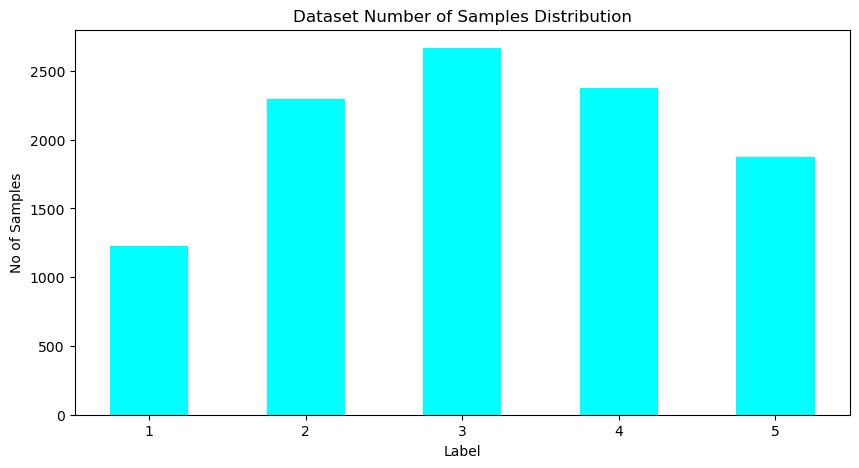

In [5]:
fig = plt.figure(figsize = (10,5))

plt.bar(range(1, len(data_items)+1), data_items, color='cyan', width=0.5)

plt.xlabel("Label")
plt.ylabel("No of Samples")
plt.title("Dataset Number of Samples Distribution")
plt.show()

From the barplot, we can see that not all cases are represented the same. Thescenario that there are 3 items in the picture has the larger dataset, while the case that only one object exists in the dataset has the less cases.

In [63]:
for i in range(1, 6):
    DIR = 'train_data/{}'.format(i)
    items = [i for i in os.listdir(DIR) if i.endswith('.jpg')] #we only need the files that end with .jpg

    print("in the folder {}, there where {} items found".format(i, len(items)))
    #we will split in 60% train, 20% test and 20 % valid set
    test_valid_split = int(len(items)*.2)
    train_set_size = len(items)-2*test_valid_split
    #print("train_test size : {}".format(train_set_size))
    #print("test_set size : {}".format(test_valid_split))
    #print("valid_set size : {}".format(test_valid_split))
    # shuffling the items in the items list to insert randomness
    random.shuffle(items)
    train_set = items[:train_set_size]
    test_set = items[train_set_size:train_set_size+test_valid_split]
    valid_set = items[train_set_size+test_valid_split:]
    #print(len(train_set))
    #print(len(test_set))
    #print(len(valid_set))
    subfolders = ['train', 'test', 'valid']
    sets = [train_set, test_set, valid_set]
    for j in range(len(subfolders)):
        subfolder = subfolders[j]
        #first check if the test folder exists 
        if os.path.exists('dataset/{}/{}'.format(subfolder,i)) and os.path.isdir('dataset/{}/{}'.format(subfolder,i)):
            shutil.rmtree('dataset/{}/{}'.format(subfolder,i))
        #copy the corresponding items to their directories
        Path("dataset/{}/{}".format(subfolder, i)).mkdir(parents=True, exist_ok=True)
        #copy the items
        for file in sets[j]:
            shutil.copyfile("train_data/{}/{}".format(i, file), "dataset/{}/{}/{}".format(subfolder, i, file))

in the folder 1, there where 1228 items found
in the folder 2, there where 2299 items found
in the folder 3, there where 2666 items found
in the folder 4, there where 2373 items found
in the folder 5, there where 1875 items found


In [64]:
splitted_dataset = [[ -1 for x in range(5)] for y in range(3)] #placeholder 
subfolders = ['train', 'test', 'valid']
for i in range(len(subfolders)):
    for j in range(1,6):
        DIR = 'dataset/{}/{}'.format(subfolders[i], j)
        count = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
        #print("for {} set and folder {}, count = {}".format(subfolders[i], j, count))
        splitted_dataset[i][j-1] = count

Now, let's make a plot to check the distribution of dataset size. If everything went out well, we should see that the distribution should be the same as in the total dataset, and the total items of validation and test datasets should be the same

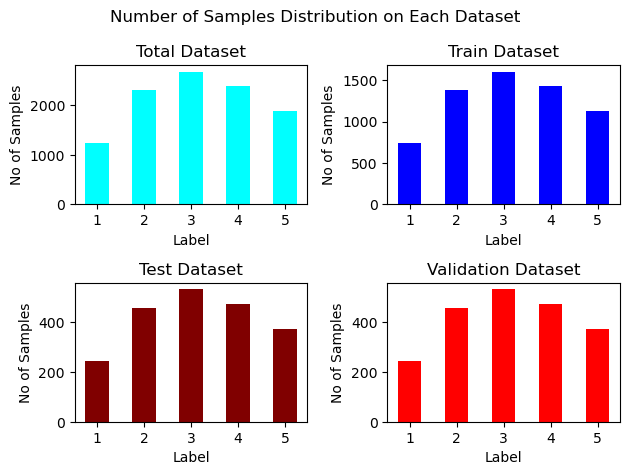

In [65]:
fig, axs = plt.subplots(2,2)
fig.suptitle("Number of Samples Distribution on Each Dataset")

#total dataset
axs[0,0].bar(range(1, len(data_items)+1), data_items, color='cyan', width=0.5)
axs[0,0].set_title('Total Dataset')

#train dataset
axs[0,1].bar(range(1, len(data_items)+1), splitted_dataset[0], color='blue', width=0.5)
axs[0,1].set_title('Train Dataset')

#test dataset
axs[1,0].bar(range(1, len(data_items)+1), splitted_dataset[1], color='maroon', width=0.5)
axs[1,0].set_title('Test Dataset')

#validation dataset
axs[1,1].bar(range(1, len(data_items)+1), splitted_dataset[2], color='red', width=0.5)
axs[1,1].set_title('Validation Dataset')


for ax in axs.flat:
    ax.set(xlabel='Label', ylabel='No of Samples')
fig.tight_layout()

Now it is time to upload the datasets to s3

In [67]:
#TODO: Upload the data to AWS S3

for subfolder in subfolders:
    filendir = 'dataset/{}'.format(subfolder)
    for root,dirs,files in os.walk(filendir):
        for file in files:
            parent_folder = root.split('/')[-1]
            if parent_folder[0]=='.':
                continue #skip hidden folders

            local_path = os.path.join(root, file)
            s3_path = os.path.join('dataset', subfolder, parent_folder, file)
            #print(local_path)
            #print(s3_path)
            try:
                client.head_object(Bucket=bucket, Key=s3_path)
                print("Path found on S3! Skipping {}...".format(s3_path))
            except:
                client.upload_file(local_path, bucket, s3_path)

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

Although, as it is stated, we do not need to perform HyperParameter Optimization, we will try to do so. In order for that to happen, we will need to create a python script, named ```hpo.py``` which will be used in the process.. We will try to optimize on 3 parameters, learning rate, batch size and number of epochs, as they are in general the ones that will impact mostly on the model efficiency.

In [4]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.005, 0.01),
    "batch_size": CategoricalParameter([16, 32, 64, 128]),
    "epochs": IntegerParameter(2, 5)
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definition = [{"Name": "Test Loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [5]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definition,
    max_jobs=4,
    max_parallel_jobs=2
)

In [8]:
tuner.fit({
        "train" : "s3://{}/{}/{}/".format(bucket, 'dataset', 'train') , 
        "test" : "s3://{}/{}/{}".format(bucket, 'dataset', 'test') ,
        "validation" : "s3://{}/{}/{}".format(bucket, 'dataset', 'valid')
}, wait=True) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [9]:
best_estimator = tuner.best_estimator()
best_estimator.hyperparameters()


2023-04-08 18:09:01 Starting - Preparing the instances for training
2023-04-08 18:09:01 Downloading - Downloading input data
2023-04-08 18:09:01 Training - Training image download completed. Training in progress.
2023-04-08 18:09:01 Uploading - Uploading generated training model
2023-04-08 18:09:01 Completed - Resource reused by training job: pytorch-training-230408-1739-003-12e9c5dd


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"16"',
 'epochs': '2',
 'lr': '0.005777151647874822',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-04-08-17-39-25-039"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-426356162139/pytorch-training-2023-04-08-17-39-25-039/source/sourcedir.tar.gz"'}

In [28]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters = {"epochs": 2, "batch_size": 16, "lr": 0.005777151647874822} #have hard coded them because hp tuning took some time and the server shutdown

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[
    CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
                "include_regex": "CrossEntropyLoss_output_0", 
                "train.save_interval": "100","eval.save_interval": "10"})
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10))
debug_config = DebuggerHookConfig(collection_configs=collection_configs)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [7]:
#TODO: Create your training estimator
estimator = PyTorch(
    entry_point="train.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.large", 
    hyperparameters=hyperparameters,
    framework_version="1.4.0",
    py_version="py3",
    rules=rules,
    debugger_hook_config=debug_config,
    profiler_config=profiler_config
)

In [8]:
# TODO: Fit your estimator
estimator.fit({
        "train" : "s3://{}/{}/{}/".format(bucket, 'dataset', 'train') , 
        "test" : "s3://{}/{}/{}".format(bucket, 'dataset', 'test') ,
        "validation" : "s3://{}/{}/{}".format(bucket, 'dataset', 'valid')
}, wait=True) 

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-09-19-03-09-446


2023-04-09 19:03:11 Starting - Starting the training job...
2023-04-09 19:03:36 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
LossNotDecreasing: InProgress
ProfilerReport: InProgress
......
2023-04-09 19:04:48 Downloading - Downloading input data......
2023-04-09 19:05:48 Training - Downloading the training image......
2023-04-09 19:06:48 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-09 19:06:35,962 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-09 19:06:35,965 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-04-09 19:06:35,976 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-09 19:06:35,979 sagemaker_pytorch_container.training INFO     Invoking user training script.

Now, we can plot the debugging output

In [9]:
training_job_name = estimator.latest_training_job.name
print("Training jobname: {}".format(training_job_name))

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

Training jobname: pytorch-training-2023-04-09-19-03-09-446
[2023-04-09 19:55:56.537 ip-172-16-184-13.ec2.internal:6680 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-426356162139/pytorch-training-2023-04-09-19-03-09-446/debug-output
[2023-04-09 19:55:59.528 ip-172-16-184-13.ec2.internal:6680 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-04-09 19:56:00.550 ip-172-16-184-13.ec2.internal:6680 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'gradient/ResNet_fc.4.bias', 'gradient/ResNet_fc.4.weight']
8
40


In [10]:
from smdebug import modes
trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN)
tensor_name = "CrossEntropyLoss_output_0"

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [11]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


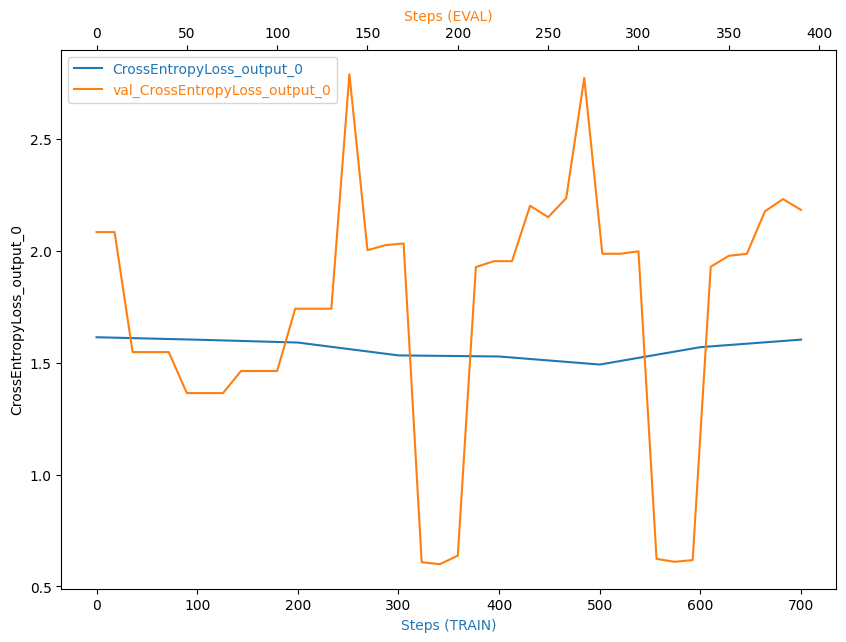

In [12]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

From the above graph we can see that there are some signs of anomalies.It is obvious that their behaviour is not smooth. We can observe spikes, and at the end the CrossEntropyLoss seems to be slightly increasing. In order to cure that behaviour we could do several things. First of all, we could change our model, maybe the last part - the part that we actually trained, since we used a pretrained one - of the model that we added is not working well. After that, we could use more input data - we should not forget that not all classes are represented equally in the dataset. Also, we could use different transformers.

Next we will printout the profiler output - and we will add the corresponding html file in the submission.

In [13]:
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-426356162139/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-426356162139/pytorch-training-2023-04-09-19-03-09-446/profiler-output


Profiler data from system is available


In [14]:
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2023-04-09 19:56:06.601 ip-172-16-184-13.ec2.internal:6680 INFO metrics_reader_base.py:134] Getting 52 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [15]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print("You will find the profiler report in {}".format(rule_output_path))
! aws s3 cp {rule_output_path} ./ --recursive

You will find the profiler report in s3://sagemaker-us-east-1-426356162139/pytorch-training-2023-04-09-19-03-09-446/rule-output
download: s3://sagemaker-us-east-1-426356162139/pytorch-training-2023-04-09-19-03-09-446/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-426356162139/pytorch-training-2023-04-09-19-03-09-446/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-426356162139/pytorch-training-2023-04-09-19-03-09-446/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-426356162139/pytorch-training-2023-04-09-19-03-09-446/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/pro

Now we can display the profiling report in the current jupyter notebook

In [16]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

Next it is time to deploy our trained model, in order to be able to use it. 

In [17]:
#not necessary step, but goot to know where the data resides
model_data_location = estimator.model_data
print(model_data_location)

s3://sagemaker-us-east-1-426356162139/pytorch-training-2023-04-09-19-03-09-446/output/model.tar.gz


Since we will be performing inference on images, we will have to use serializer and deserializer

In [9]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

If something goes wrong with the kernel, we do not need to retrain the model, we can use the following

In [7]:
#from sagemaker.pytorch import PyTorch
training_job_name = "pytorch-training-2023-04-09-19-03-09-446"
estimator = PyTorch.attach(training_job_name)


2023-04-09 19:55:42 Starting - Preparing the instances for training
2023-04-09 19:55:42 Downloading - Downloading input data
2023-04-09 19:55:42 Training - Training image download completed. Training in progress.
2023-04-09 19:55:42 Uploading - Uploading generated training model
2023-04-09 19:55:42 Completed - Training job completed


Now it is time to create and deploy the model that we will use for inference

In [21]:
model_data_location = "s3://sagemaker-us-east-1-426356162139/pytorch-training-2023-04-09-19-03-09-446/output/model.tar.gz"
pytorch_model = PyTorchModel(
    model_data=model_data_location,
    role=role, 
    entry_point='inference.py',
    py_version='py3',
    framework_version='1.4',
    predictor_cls=ImagePredictor) 
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.large")

----!

In [22]:
img_loc = "train_data/2/00878.jpg"

with open (img_loc, 'rb') as f :
    bimage = f.read()

In [23]:
from PIL import Image
import io
image = Image.open(io.BytesIO(bimage))

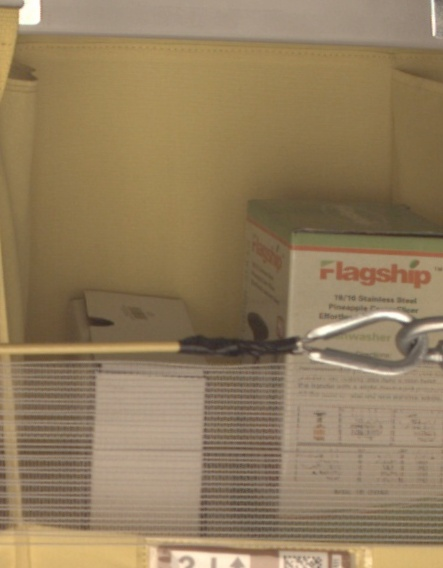

In [24]:
display(image)

In [32]:
response2=predictor.predict(bimage, initial_args={"ContentType": "image/jpeg"})
print("The predictor's response: {}".format(np.argmax(response2[0])+1))

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary with message "No module named 'smdebug'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_inference/transformer.py", line 110, in transform
    self.validate_and_initialize(model_dir=model_dir)
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_inference/transformer.py", line 158, in validate_and_initialize
    self._model = self._model_fn(model_dir)
  File "/opt/ml/model/code/inference.py", line 53, in model_fn
    checkpoint = torch.load(f , map_location =device)
  File "/opt/conda/lib/python3.6/site-packages/torch/serialization.py", line 529, in load
    return _legacy_load(opened_file, map_location, pickle_module, **pickle_load_args)
  File "/opt/conda/lib/python3.6/site-packages/torch/serialization.py", line 702, in _legacy_load
    result = unpickler.load()
ModuleNotFoundError: No module named 'smdebug'
". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2023-04-10-07-21-45-220 in account 426356162139 for more information.

Delete the endpoint to avoid extra charges.

In [33]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-04-10-07-21-45-220
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-04-10-07-21-45-220


## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.

Done in previous steps

In [ ]:
#TODO: Create your hyperparameter search space

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

In [ ]:
# TODO: Find the best hyperparameters

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

Done in previous steps

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?


Done in previous steps

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [30]:
# TODO: Train your model on Multiple Instances
multi_estimator = PyTorch(
    entry_point='train.py',
    role=role,
    instance_count=2,
    instance_type= 'ml.g4dn.xlarge', #'ml.c4.2xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=debug_config,
    profiler_config=profiler_config
)


multi_estimator.fit({
        "train" : "s3://{}/{}/{}/".format(bucket, 'dataset', 'train') , 
        "test" : "s3://{}/{}/{}".format(bucket, 'dataset', 'test') ,
        "validation" : "s3://{}/{}/{}".format(bucket, 'dataset', 'valid')
}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-10-07-26-35-530


2023-04-10 07:26:38 Starting - Starting the training job...
2023-04-10 07:27:05 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
LossNotDecreasing: InProgress
ProfilerReport: InProgress
......
2023-04-10 07:28:05 Downloading - Downloading input data...
2023-04-10 07:28:45 Training - Downloading the training image......
2023-04-10 07:29:46 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-10 07:29:46,363 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2023-04-10 07:29:46,394 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-10 07:29:46,396 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-10 07:29:46,557 sagemaker-containers INFO     Module default_user_module_name does not provide a set